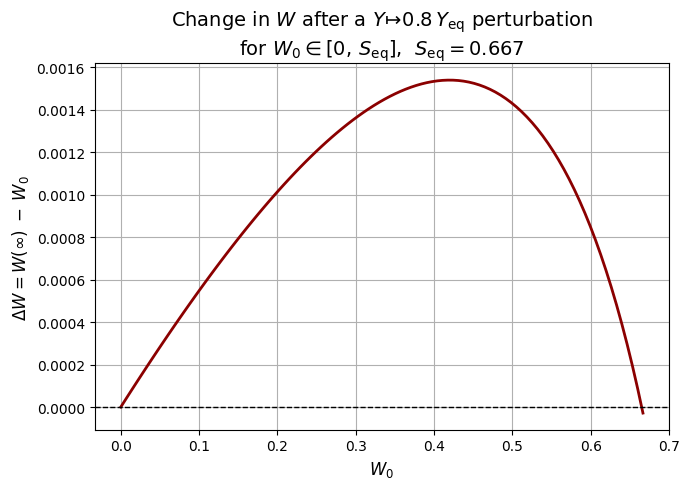

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def compute_nontrivial_slice(W_birth, W_death, Y_birth, Y_death):
    Q1 = W_death / W_birth
    Q2 = Y_death / Y_birth

    disc_W = (1 - Q1 + Q2)**2 - 4 * Q2
    W_equil1 = W_equil2 = np.nan
    if disc_W >= 0:
        sqrt_disc_W = np.sqrt(disc_W)
        W_equil1 = 0.5 * ((1 - Q1 + Q2) + sqrt_disc_W)
    else:
        return None, None
        

    disc_Y = (1 - Q2 + Q1)**2 - 4 * Q1
    Y_equil1 = Y_equil2 = np.nan
    if disc_Y >= 0:
        sqrt_disc_Y = np.sqrt(disc_Y)
        Y_equil1 = 0.5 * ((1 - Q2 + Q1) + sqrt_disc_Y)
    else:
        return None, None
    
    return W_equil1, Y_equil1
    

    

def simulate_to_equilibrium(V0, W0, Y0, X0, Z0,
                            W_birth, Y_birth, W_death, Y_death,
                            X_in, Z_in, X_out, Z_out,
                            Time, dt,
                            use_X, use_Z):
    """
    Integrate the system from t=0 to t=Time with initial conditions
    V(0)=V0, W(0)=W0, Y(0)=Y0, X(0)=X0, Z(0)=Z0.
    All extinction‐related parameters are set to zero here.
    Returns the full time‐series arrays (t, V, W, Y, X, Z).
    """
    # Compute scalers
    X_scaler = X_out / X_in if (use_X and X_in>0) else 1.0
    Z_scaler = Z_out / Z_in if (use_Z and Z_in>0) else 1.0

    # Number of time‐steps
    N = int(np.ceil(Time / dt)) + 1
    t = np.linspace(0, Time, N)

    V = np.zeros(N)
    W = np.zeros(N)
    Y = np.zeros(N)
    X = np.zeros(N)
    Z = np.zeros(N)

    # Store “unscaled” initial X, Z so that final re‐scaling yields correct values
    V[0] = V0
    W[0] = W0
    Y[0] = Y0
    X[0] = X0 
    Z[0] = Z0 

    for i in range(1, N):
        Vi = V[i-1]
        Wi = W[i-1]
        Yi = Y[i-1]
        Xi = X[i-1]
        Zi = Z[i-1]

        # dV/dt and dW/dt from the original code
        dV = W_birth * (1 - Wi - Vi) * Vi * Yi - W_death * Vi
        dW = W_birth * (1 - Wi - Vi) * Wi * Yi - W_death * Wi

        # dY/dt
        dY = Y_birth * (1 - Yi) * Yi * (Vi + Wi) - Y_death * Yi

        # If X–coupling is enabled:
        if use_X:
            dW += X_out * Xi - X_in * Wi

        # If Z–coupling is enabled:
        if use_Z:
            dY += Z_out * Zi - Z_in * Yi

        # dX/dt, dZ/dt always defined
        dX = - X_out * Xi + X_in * Wi
        dZ = - Z_out * Zi + Z_in * Yi

        # Euler update
        V[i] = Vi + dt * dV
        W[i] = Wi + dt * dW
        Y[i] = Yi + dt * dY
        X[i] = Xi + dt * dX
        Z[i] = Zi + dt * dZ

        # Ensure nonnegativity:
        V[i] = max(V[i], 0.0)
        W[i] = max(W[i], 0.0)
        Y[i] = max(Y[i], 0.0)
        X[i] = max(X[i], 0.0)
        Z[i] = max(Z[i], 0.0)

    # Rescale X, Z back to “true” units for plotting or analysis
    X_plot = X * X_scaler
    Z_plot = Z * Z_scaler

    return t, V, W, Y, X_plot, Z_plot

def analyze_response_over_slice(W_birth, Y_birth, W_death, Y_death,
                                X_in, Z_in, X_out, Z_out,
                                Time=200.0, dt=0.01,
                                use_X=True, use_Z=True,
                                num_points=100, severity=0.8):
    """
    1) Find S_eq and Y_eq for the nontrivial equilibrium.
    2) For each W0 in [0, S_eq], set V0 = S_eq - W0, Y0 = Y_eq, X0 = X_eq(W0), Z0 = Z_eq(Y_eq).
       Then immediately perturb Y0 -> 0.8 * Y_eq, simulate, and measure the final W(t_final).
       Let DeltaW = W(t_final) - W0.  Plot DeltaW vs W0.
    """
    # (1) Compute S_eq and Y_eq
    S_eq, Y_eq = compute_nontrivial_slice(W_birth, W_death, Y_birth, Y_death)
    if (S_eq is None) or (Y_eq is None):
        raise RuntimeError("No strictly positive, nontrivial equilibrium exists for these parameters.")

    # Precompute X_scaler, Z_scaler
    X_scaler = X_out / X_in if use_X and (X_in>0) else 1.0
    Z_scaler = Z_out / Z_in if use_Z and (Z_in>0) else 1.0

    # Equilibrium X and Z as functions of W_eq and Y_eq, respectively
    #   At equilibrium:  dX/dt = 0  =>  X_eq = (X_in / X_out) * W_eq
    #                   dZ/dt = 0  =>  Z_eq = (Z_in / Z_out) * Y_eq
    #
    # But our simulation stores X[i] = X_true / X_scaler, so we pass X0 = X_eq (true) 
    # and the code immediately divides by X_scaler.  Same for Z0.

    # (2) Set up W0 grid
    W0_values = np.linspace(0.0, S_eq, num_points)
    DeltaW = np.zeros_like(W0_values)

    for idx, W0 in enumerate(W0_values):
        V0 = S_eq - W0
        # true equilibrium X, Z
        X_eq = (X_in / X_out) * W0 if use_X else 0.0
        Z_eq = (Z_in / Z_out) * Y_eq if use_Z else 0.0

        # Initial Y = Y_eq, then perturb at t=0:
        Y0 = severity * Y_eq

        # Simulate up to Time with all extinction params = 0:
        t_arr, V_arr, W_arr, Y_arr, X_arr, Z_arr = simulate_to_equilibrium(
            V0=V0, W0=W0, Y0=Y0, X0=X_eq, Z0=Z_eq,
            W_birth=W_birth, Y_birth=Y_birth,
            W_death=W_death, Y_death=Y_death,
            X_in=X_in, Z_in=Z_in,
            X_out=X_out, Z_out=Z_out,
            Time=Time, dt=dt,
            use_X=use_X, use_Z=use_Z
        )

        # Assume t=Time is “long enough” that the solution has converged to its new equilibrium
        W_final = W_arr[-1]
        DeltaW[idx] = W_final - W0

    # (3) Plot DeltaW vs W0
    plt.figure(figsize=(7, 5))
    plt.plot(W0_values, DeltaW, linewidth=2, color='darkred')
    plt.axhline(0.0, color='black', linestyle='--', lw=1)
    plt.xlabel(r'$W_{0}$', fontsize=12)
    plt.ylabel(r'$\Delta W = W(\infty)\;-\;W_{0}$', fontsize=12)
    plt.title(
        r'Change in $W$ after a $Y\!\mapsto\!0.8\,Y_{\rm eq}$ perturbation' + '\n'
        + r'for $W_{0}\in [0,\,S_{\rm eq}]$,  $S_{\rm eq}=%.3f$' % (S_eq,),
        fontsize=14
    )
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return W0_values, DeltaW

# =========================
# Example usage (replace numerical parameters as needed):
#
if __name__ == "__main__":
    # === User‐supplied parameters ===
    W_birth = 0.4
    W_death = 0.1
    Y_birth = 0.9
    Y_death = 0.15

    X_in = 0.2
    X_out = 0.1
    Z_in = 0.5
    Z_out = 0.25

    # Simulation time‐horizon and time‐step
    Time = 200.0
    dt = 0.01

    use_X = True
    use_Z = False

    # Number of grid points for W0 ∈ [0, S_eq]
    num_points = 100

    # ========= Run the analysis =========
    W0_vals, DeltaW_vals = analyze_response_over_slice(
        W_birth=W_birth, Y_birth=Y_birth,
        W_death=W_death, Y_death=Y_death,
        X_in=X_in, Z_in=Z_in,
        X_out=X_out, Z_out=Z_out,
        Time=Time, dt=dt,
        use_X=use_X, use_Z=use_Z,
        num_points=num_points, severity=0.2
    )

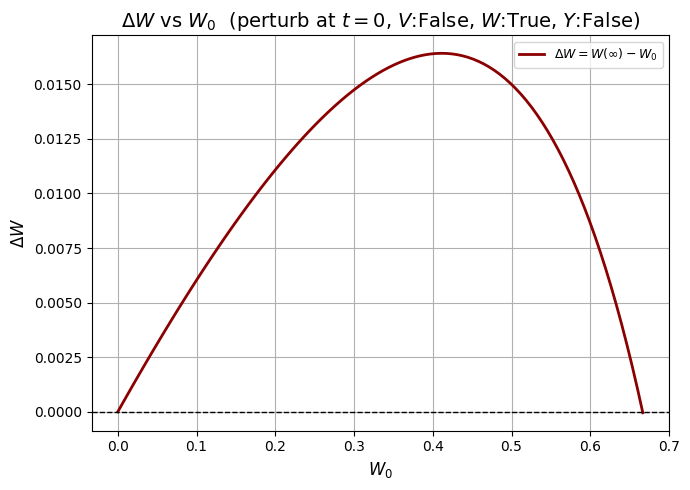

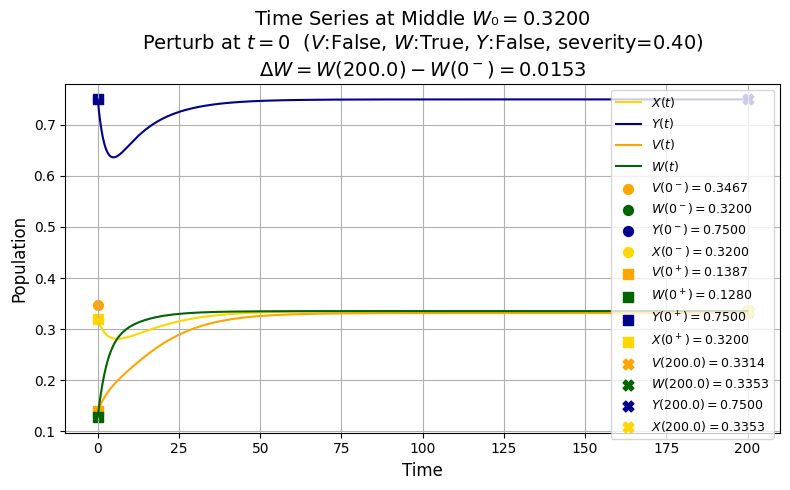

W_eq = 0.666667, Y_eq = 0.750000
Middle W0 = 0.320000
W_mid_pre = 0.320000
W_mid (after perturb) = 0.128000
W_final = 0.335264
ΔW_mid = 0.015264


In [37]:
import numpy as np
import matplotlib.pyplot as plt

def compute_nontrivial_slice(W_birth, W_death, Y_birth, Y_death):
    """
    Compute the positive nontrivial equilibrium (W_eq, Y_eq) by solving:
      Q1 = W_death / W_birth,   Q2 = Y_death / Y_birth
      W_eq = ½ [ (1 − Q1 + Q2) + sqrt((1 − Q1 + Q2)^2 − 4·Q2 ) ]
      Y_eq = ½ [ (1 − Q2 + Q1) + sqrt((1 − Q2 + Q1)^2 − 4·Q1 ) ]
    Returns (W_eq, Y_eq) if both lie in (0,1); otherwise (None, None).
    """
    Q1 = W_death / W_birth
    Q2 = Y_death / Y_birth

    disc_W = (1 - Q1 + Q2)**2 - 4 * Q2
    if disc_W < 0:
        return None, None
    sqrt_disc_W = np.sqrt(disc_W)
    W_equil = 0.5 * ((1 - Q1 + Q2) + sqrt_disc_W)
    if not (0.0 < W_equil < 1.0):
        return None, None

    disc_Y = (1 - Q2 + Q1)**2 - 4 * Q1
    if disc_Y < 0:
        return None, None
    sqrt_disc_Y = np.sqrt(disc_Y)
    Y_equil = 0.5 * ((1 - Q2 + Q1) + sqrt_disc_Y)
    if not (0.0 < Y_equil < 1.0):
        return None, None

    return W_equil, Y_equil

def simulate_segment(V0, W0, Y0, X0, Z0,
                     W_birth, Y_birth, W_death, Y_death,
                     X_in, Z_in, X_out, Z_out,
                     duration, dt,
                     use_X, use_Z):
    """
    Integrate from t=0 to t=duration with initial conditions
      V(0)=V0, W(0)=W0, Y(0)=Y0, X(0)=X0, Z(0)=Z0.
    Returns:
      t_segment,
      V_segment, W_segment, Y_segment,
      X_raw (unscaled), Z_raw (unscaled),
      X_plot = X_raw * X_scaler, Z_plot = Z_raw * Z_scaler.
    """
    X_scaler = X_out / X_in if (use_X and X_in > 0) else 1.0
    Z_scaler = Z_out / Z_in if (use_Z and Z_in > 0) else 1.0

    N = int(np.ceil(duration / dt)) + 1
    t = np.linspace(0.0, duration, N)

    V = np.zeros(N)
    W = np.zeros(N)
    Y = np.zeros(N)
    X_raw = np.zeros(N)
    Z_raw = np.zeros(N)

    V[0] = V0
    W[0] = W0
    Y[0] = Y0
    X_raw[0] = X0
    Z_raw[0] = Z0

    for i in range(1, N):
        Vi = V[i-1]
        Wi = W[i-1]
        Yi = Y[i-1]
        Xi = X_raw[i-1]
        Zi = Z_raw[i-1]

        # dV/dt, dW/dt
        dV = W_birth * (1 - Wi - Vi) * Vi * Yi - W_death * Vi
        dW = W_birth * (1 - Wi - Vi) * Wi * Yi - W_death * Wi

        # dY/dt
        dY = Y_birth * (1 - Yi) * Yi * (Vi + Wi) - Y_death * Yi

        # X-coupling
        if use_X:
            dW += X_out * Xi - X_in * Wi
        # Z-coupling
        if use_Z:
            dY += Z_out * Zi - Z_in * Yi

        # dX/dt, dZ/dt
        dX = - X_out * Xi + X_in * Wi
        dZ = - Z_out * Zi + Z_in * Yi

        # Euler update
        V[i] = Vi + dt * dV
        W[i] = Wi + dt * dW
        Y[i] = Yi + dt * dY
        X_raw[i] = Xi + dt * dX
        Z_raw[i] = Zi + dt * dZ

        # Enforce nonnegativity
        V[i] = max(V[i], 0.0)
        W[i] = max(W[i], 0.0)
        Y[i] = max(Y[i], 0.0)
        X_raw[i] = max(X_raw[i], 0.0)
        Z_raw[i] = max(Z_raw[i], 0.0)

    X_plot = X_raw * X_scaler
    Z_plot = Z_raw * Z_scaler

    return t, V, W, Y, X_raw, Z_raw, X_plot, Z_plot

def analyze_and_plot(W_birth, Y_birth, W_death, Y_death,
                     X_in, Z_in, X_out, Z_out,
                     Time=200.0, dt=0.01,
                     use_X=True, use_Z=True,
                     num_points=100,
                     severity=0.8, perturb_time=0.0,
                     perturb_W=False, perturb_Y=True):
    """
    1) Compute (W_eq, Y_eq).
    2) Plot ΔW vs W0 with perturbation at t=0 for all W0.
    3) “Test” plot at middle W0 = W_eq/2: show equilibrium marker, immediate perturb at t=0,
       then simulate to Time, plotting V, W, Y, X.
    """
    # --- (1) Compute equilibrium ---
    W_eq, Y_eq = compute_nontrivial_slice(W_birth, W_death, Y_birth, Y_death)
    if (W_eq is None) or (Y_eq is None):
        raise RuntimeError("No positive, nontrivial equilibrium exists.")

    # --- Precompute scalers for X, Z (for plotting markers) ---
    X_scaler = X_out / X_in if (use_X and X_in > 0) else 1.0
    Z_scaler = Z_out / Z_in if (use_Z and Z_in > 0) else 1.0

    # ================================
    # (2) ΔW vs W0 WITH perturbation at t=0
    # ================================
    W0_values = np.linspace(0.0, W_eq, num_points)
    DeltaW = np.zeros_like(W0_values)

    for idx, W0 in enumerate(W0_values):
        V0 = W_eq - W0
        X0 = (X_in / X_out) * W0 if use_X else 0.0
        Z0 = (Z_in / Z_out) * Y_eq if use_Z else 0.0

        # Immediately apply perturbation at t=0:
        if perturb_W:
            V0p = (severity * V0) 
            W0p = (severity * W0) 
        else:
            V0p = V0
            W0p = W0

        Y0p = (severity * Y_eq) if perturb_Y else Y_eq

        # Simulate [0 → Time] from perturbed initial condition
        _, _, W_full, _, _, _, _, _ = simulate_segment(
            V0=V0p, W0=W0p, Y0=Y0p, X0=X0, Z0=Z0,
            W_birth=W_birth, Y_birth=Y_birth,
            W_death=W_death, Y_death=Y_death,
            X_in=X_in, Z_in=Z_in,
            X_out=X_out, Z_out=Z_out,
            duration=Time, dt=dt,
            use_X=use_X, use_Z=use_Z
        )
        W_final = W_full[-1]
        # ΔW measured relative to pre-perturbation baseline W0
        DeltaW[idx] = W_final - W0

    # Plot ΔW vs W0
    plt.figure(figsize=(7, 5))
    plt.plot(W0_values, DeltaW, color='darkred', linewidth=2,
             label=r'$\Delta W = W(\infty)-W_{0}$')
    plt.axhline(0.0, color='black', linestyle='--', lw=1)

    # Adjust y-limits with a small margin
    y_min = np.min(DeltaW)
    y_max = np.max(DeltaW)
    margin = 0.05 * (y_max - y_min) if (y_max - y_min) > 0 else 0.05
    plt.ylim(y_min - margin, y_max + margin)

    plt.xlabel(r'$W_{0}$', fontsize=12)
    plt.ylabel(r'$\Delta W$', fontsize=12)
    plt.title(
        r'$\Delta W$ vs $W_{0}$  (perturb at $t=0$, $V$:%s, $W$:%s, $Y$:%s)' 
        % (perturb_V, perturb_W, perturb_Y),
        fontsize=14
    )
    plt.legend(loc='upper right', fontsize=9)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ============================================
    # (3) “Test” plot at middle W0 = W_eq / 2 WITH perturbation at t=0
    # ============================================
    W0_mid = 0.48 * W_eq
    V0_mid = W_eq - W0_mid
    X0_mid = (X_in / X_out) * W0_mid if use_X else 0.0
    Z0_mid = (Z_in / Z_out) * Y_eq if use_Z else 0.0

    # Equilibrium values just before perturbation
    V_eq_peak = V0_mid
    W_eq_peak = W0_mid
    Y_eq_peak = Y_eq
    X_eq_peak = X0_mid * X_scaler
    Z_eq_peak = Z0_mid * Z_scaler

    # Immediately apply perturbation at t=0+
    V_mid = (severity * V_eq_peak) if perturb_W else V_eq_peak
    W_mid = (severity * W_eq_peak) if perturb_W else W_eq_peak
    Y_mid = (severity * Y_eq_peak) if perturb_Y else Y_eq_peak

    # Simulate [0 → Time] from perturbed initial condition
    t_full, V_full, W_full, Y_full, X_raw_full, Z_raw_full, X_plot_full, Z_plot_full = simulate_segment(
        V0=V_mid, W0=W_mid, Y0=Y_mid, X0=X0_mid, Z0=Z0_mid,
        W_birth=W_birth, Y_birth=Y_birth,
        W_death=W_death, Y_death=Y_death,
        X_in=X_in, Z_in=Z_in,
        X_out=X_out, Z_out=Z_out,
        duration=Time, dt=dt,
        use_X=use_X, use_Z=use_Z
    )

    V_final_m = V_full[-1]
    W_final_m = W_full[-1]
    Y_final_m = Y_full[-1]
    X_final_m = X_plot_full[-1]
    Z_final_m = Z_plot_full[-1] if use_Z else None
    delta_W_mid = W_final_m - W_eq_peak

    # Plot time‐series for middle W0, including X(t)
    plt.figure(figsize=(8, 5))
    if use_X:
        plt.plot(t_full, X_plot_full, label=r'$X(t)$', color='gold', linewidth=1.5)
    if use_Z:
        plt.plot(t_full, Z_plot_full, label=r'$Z(t)$', color='skyblue', linewidth=1.5)
    plt.plot(t_full, Y_full, label=r'$Y(t)$', color='darkblue', linewidth=1.5)
    plt.plot(t_full, V_full, label=r'$V(t)$', color='orange', linewidth=1.5)
    plt.plot(t_full, W_full, label=r'$W(t)$', color='darkgreen', linewidth=1.5)

    # Marker at t = 0 (just before perturbation, equilibrium)
    plt.scatter(0.0, V_eq_peak, color='orange', marker='o', s=50,
                label=f'$V(0^-)={V_eq_peak:.4f}$')
    plt.scatter(0.0, W_eq_peak, color='darkgreen', marker='o', s=50,
                label=f'$W(0^-)={W_eq_peak:.4f}$')
    plt.scatter(0.0, Y_eq_peak, color='darkblue', marker='o', s=50,
                label=f'$Y(0^-)={Y_eq_peak:.4f}$')
    if use_X:
        plt.scatter(0.0, X_eq_peak, color='gold', marker='o', s=50,
                    label=f'$X(0^-)={X_eq_peak:.4f}$')
    if use_Z:
        plt.scatter(0.0, Z_eq_peak, color='skyblue', marker='o', s=50,
                    label=f'$Z(0^-)={Z_eq_peak:.4f}$')

    # Marker at t = 0 (just after perturbation)
    plt.scatter(0.0, V_mid, color='orange', marker='s', s=50,
                label=f'$V(0^+)={V_mid:.4f}$')
    plt.scatter(0.0, W_mid, color='darkgreen', marker='s', s=50,
                label=f'$W(0^+)={W_mid:.4f}$')
    plt.scatter(0.0, Y_mid, color='darkblue', marker='s', s=50,
                label=f'$Y(0^+)={Y_mid:.4f}$')
    if use_X:
        plt.scatter(0.0, X0_mid * X_scaler, color='gold', marker='s', s=50,
                    label=f'$X(0^+)={X0_mid * X_scaler:.4f}$')
    if use_Z:
        plt.scatter(0.0, Z0_mid * Z_scaler, color='skyblue', marker='s', s=50,
                    label=f'$Z(0^+)={Z0_mid * Z_scaler:.4f}$')

    # Marker at t = Time (final equilibrium)
    plt.scatter(Time, V_final_m, color='orange', marker='X', s=60,
                label=f'$V({Time:.1f})={V_final_m:.4f}$')
    plt.scatter(Time, W_final_m, color='darkgreen', marker='X', s=60,
                label=f'$W({Time:.1f})={W_final_m:.4f}$')
    plt.scatter(Time, Y_final_m, color='darkblue', marker='X', s=60,
                label=f'$Y({Time:.1f})={Y_final_m:.4f}$')
    if use_X:
        plt.scatter(Time, X_final_m, color='gold', marker='X', s=60,
                    label=f'$X({Time:.1f})={X_final_m:.4f}$')
    if use_Z:
        plt.scatter(Time, Z_final_m, color='skyblue', marker='X', s=60,
                    label=f'$Z({Time:.1f})={Z_final_m:.4f}$')

    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Population', fontsize=12)
    plt.title(
        f'Time Series at Middle $W₀ = {W0_mid:.4f}$\n'
        f'Perturb at $t=0$  ($V$:{perturb_V}, $W$:{perturb_W}, $Y$:{perturb_Y}, severity={severity:.2f})\n'
        f'$\Delta W = W({Time:.1f}) - W(0^-) = {delta_W_mid:.4f}$',
        fontsize=14
    )
    plt.legend(loc='upper right', fontsize=9, ncol=1)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        'W_eq': W_eq,
        'Y_eq': Y_eq,
        'W0_grid': W0_values,
        'DeltaW': DeltaW,
        'W0_mid': W0_mid,
        'V_mid_pre': V_eq_peak,
        'W_mid_pre': W_eq_peak,
        'Y_mid_pre': Y_eq_peak,
        'V_mid': V_mid,
        'W_mid': W_mid,
        'Y_mid': Y_mid,
        'X_mid_raw': X0_mid * X_scaler,
        'Z_mid_raw': Z0_mid * Z_scaler if use_Z else None,
        'V_final': V_final_m,
        'W_final': W_final_m,
        'Y_final': Y_final_m,
        'X_final': X_final_m,
        'Z_final': Z_final_m,
        'delta_W_mid': delta_W_mid,
        't_full': t_full,
        'V_full': V_full,
        'W_full': W_full,
        'Y_full': Y_full,
        'X_full': X_plot_full if use_X else None,
        'Z_full': Z_plot_full if use_Z else None
    }


# =========================
# Example usage (replace numerical parameters as needed):
if __name__ == "__main__":
    # === User‐supplied parameters ===
    W_birth = 0.4
    W_death = 0.1
    Y_birth = 0.9
    Y_death = 0.15

    X_in = 0.2
    X_out = 0.1
    Z_in = 0.5
    Z_out = 0.25

    Time = 200.0
    dt = 0.01

    use_X = True
    use_Z = False

    num_points = 100
    severity = 0.4         # Fraction to multiply (V, W, or Y) at perturbation
    perturb_time = 20.0     # Perturbation at t=0

    # Choose which variables to perturb in the test plot:
    perturb_W = True
    perturb_Y = False

    results = analyze_and_plot(
        W_birth=W_birth, Y_birth=Y_birth,
        W_death=W_death, Y_death=Y_death,
        X_in=X_in, Z_in=Z_in,
        X_out=X_out, Z_out=Z_out,
        Time=Time, dt=dt,
        use_X=use_X, use_Z=use_Z,
        num_points=num_points,
        severity=severity, perturb_time=perturb_time,
        perturb_W=perturb_W, perturb_Y=perturb_Y
    )

    # Print numeric summaries
    print(f"W_eq = {results['W_eq']:.6f}, Y_eq = {results['Y_eq']:.6f}")
    print(f"Middle W0 = {results['W0_mid']:.6f}")
    print(f"W_mid_pre = {results['W_mid_pre']:.6f}")
    print(f"W_mid (after perturb) = {results['W_mid']:.6f}")
    print(f"W_final = {results['W_final']:.6f}")
    print(f"ΔW_mid = {results['delta_W_mid']:.6f}")